In [1]:
import pandas as pd
import numpy as np
import collections

import re
import nltk
from nltk.corpus import stopwords 
import nltk.data
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import r2_score, log_loss, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

/Users/shen/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1. Load Data

In [2]:
df = pd.read_excel('https://query.data.world/s/6vej4vorotu7adyagro2alarorapwj')
transcript = pd.read_csv('ted-talks/transcripts.csv')
words_map = pd.read_csv('mapping.csv')

df['transcript'] = transcript.transcript

In [3]:
selected_df = df[['transcript','norm_persuasive','languages','WC']]

# 1. EDA

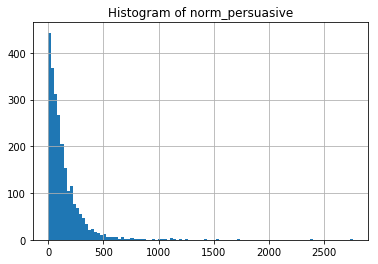

In [4]:
selected_df.norm_persuasive.hist(bins=100)
plt.title('Histogram of norm_persuasive')
plt.show()

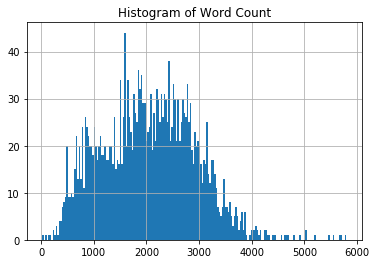

In [5]:
selected_df.WC.hist(bins=200)
plt.title('Histogram of Word Count')
plt.show()

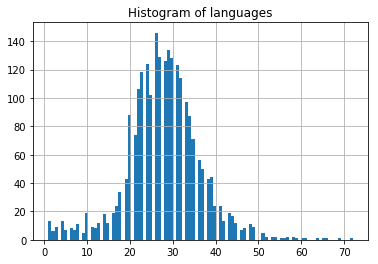

In [6]:
selected_df.languages.hist(bins=100)
plt.title('Histogram of languages')
plt.show()

# 3. Feature Engineering

In [7]:
# tokenizing sentences
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
def sentence_number(x):
    x = str(x)
    x=re.sub("[\(\[].*?[\)\]]", "", x)
    return len(tokenizer.tokenize(x))

# compute number of sentences for each talk
selected_df['stn_num'] = selected_df['transcript'].map(sentence_number)
selected_df = selected_df[selected_df.stn_num > 1]

# compute number of average words per sentence
selected_df['avg_word_per_stn'] = selected_df['WC'] / selected_df['stn_num']

# log transform the persuasive score
selected_df.norm_persuasive = [a+0.0000001 if a == 0 else a for a in selected_df.norm_persuasive]

selected_df['new_num'] = np.log(selected_df.norm_persuasive)

/Users/shen/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [11]:
selected_df.new_num.describe()

count    2249.000000
mean        4.383444
std         1.369875
min       -16.118096
25%         3.669486
50%         4.563530
75%         5.250236
max         7.922488
Name: new_num, dtype: float64

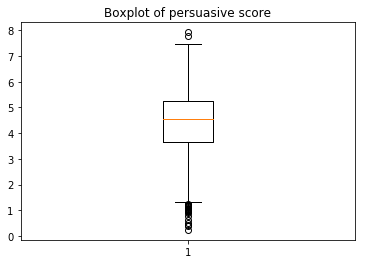

In [8]:
plt.boxplot(selected_df[selected_df.new_num > 0]['new_num'])
plt.title('Boxplot of persuasive score')
plt.show()

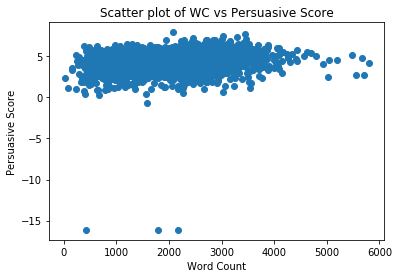

In [10]:
plt.scatter(selected_df.WC, selected_df.new_num)
plt.title('Scatter plot of WC vs Persuasive Score')
plt.xlabel('Word Count')
plt.ylabel('Persuasive Score')
plt.show()

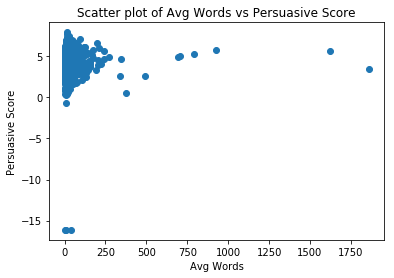

In [12]:
plt.scatter(selected_df.avg_word_per_stn, selected_df.new_num)
plt.title('Scatter plot of Avg Words vs Persuasive Score')
plt.xlabel('Avg Words')
plt.ylabel('Persuasive Score')
plt.show()

In [14]:
# build word classification dictionary
word_category_dict = {}
for i in range(len(words_map)):
    word_category_dict[words_map['keys'][i]] = words_map['values'][i]

## 3.1 Stop words

In [13]:
def review_to_wordlist(x, remove_stopwords=False): #stop word as optional
    x = str(x)
    x=re.sub("[\(\[].*?[\)\]]", "", x)
    
    wordnet_lemmatizer = WordNetLemmatizer()
    x = re.sub("[^a-zA-Z]", " ", x)    
    x = x.lower().split()

    if remove_stopwords:
        stops = set(stopwords.words("english")) # set is faster than list
        x = [wordnet_lemmatizer.lemmatize(word) for word in x if word not in stops]
    return list(map(word_category_dict.get, x))

In [15]:
def review_to_wordlist_no(x, remove_stopwords=True): #stop word as optional
    x = str(x)
    x=re.sub("[\(\[].*?[\)\]]", "", x)
    
    wordnet_lemmatizer = WordNetLemmatizer()
    x = re.sub("[^a-zA-Z]", " ", x)    
    x = x.lower().split()

    if remove_stopwords:
        stops = set(stopwords.words("english")) # set is faster than list
        x = [wordnet_lemmatizer.lemmatize(word) for word in x if word not in stops]
    return list(map(word_category_dict.get, x))

In [16]:
selected_df['new_transcript'] = selected_df['transcript'].apply(review_to_wordlist)
selected_df['new_transcript_no'] = selected_df['transcript'].apply(review_to_wordlist_no)

In [17]:
selected_df.tail()

,transcript,norm_persuasive,languages,WC,stn_num,avg_word_per_stn,new_num,new_transcript,new_transcript_no
2462,"So, Ma was trying to explain something to me a...",95.397046,20,1563,58,26.948276,4.558048,"[9, 79, 29, 9, 29, 9, 9, 29, 9, 29, 45, 29, 29...","[9, 9, 9, 45, 59, 0, 9, 29, 29, 29, 15, 29, 29..."
2463,This is a picture of a sunset on Mars taken by...,77.260146,17,1111,26,42.730769,4.347178,"[29, 29, 29, 9, 29, 29, 5, 29, 19, 29, 29, 19,...","[9, 5, 71, 29, 19, 60, 19, 71, 54, 19, 54, 29,..."
2464,"In my early days as a graduate student, I went...",62.870292,14,3180,57,55.789474,4.141074,"[29, 9, 29, 29, 29, 29, 23, 23, 9, 29, 29, 29,...","[29, 29, 23, 23, 29, 19, 29, 27, 43, 9, 9, 11,..."
2465,I took a cell phone and accidentally made myse...,9.505553,8,1437,119,12.075630,2.251876,"[9, 29, 29, 44, 22, 29, 78, 29, 9, 66, 9, 29, ...","[29, 44, 22, 78, 29, 66, 9, 9, 57, 22, 63, 32,..."
2466,"We humans are becoming an urban species, so ci...",9.068684,16,2416,75,32.213333,2.204827,"[9, 44, 29, 29, 29, 27, 34, 9, 27, 9, 29, 9, 4...","[44, 29, 27, None, 29, 44, 15, 29, 59, 29, 57,..."


In [18]:
def new_df(ser):
    m = collections.Counter(ser[0])
    sum_values =sum(m.values())
    for key in dict(m):
        m[key] = [m[key]*100/sum_values]
    df1 = pd.DataFrame.from_dict(dict(m))
    
    for l in ser[1:]:
        m = collections.Counter(l)
        sum_values =sum(m.values())
        for key in dict(m):
            m[key] = [m[key]*100/sum_values]
        df = pd.DataFrame.from_dict(dict(m))
        df1 = pd.concat([df1,df], axis=0, ignore_index=True)
    df1 = df1.fillna(0)
    #df1 = df1.reindex(selected_df.index)
    df1.index = selected_df.index
    return df1

In [19]:
word_count_df = new_df(selected_df.new_transcript)
word_count_df_no = new_df(selected_df.new_transcript_no)

/Users/shen/anaconda/envs/python36/lib/python3.6/site-packages/pandas/core/indexes/api.py:87: RuntimeWarning: '<' not supported between instances of 'int' and 'NoneType', sort order is undefined for incomparable objects
  result = result.union(other)


In [20]:
count_words_df =  selected_df.join(word_count_df, how='outer')
count_words_df_no =  selected_df.join(word_count_df_no, how='outer')

# 4. Modeling

## 4.1 With stop words

In [21]:
X, y = count_words_df.drop(['transcript','norm_persuasive','new_num','new_transcript','new_transcript_no'],axis=1),\
        [1 if a > 3.5 else 0 for a in count_words_df.new_num]

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=10)

### 4.1.1 RF

In [238]:
rf = RandomForestClassifier(n_estimators=100, random_state=10)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)
y_pred_proba_rf = rf.predict_proba(x_test)

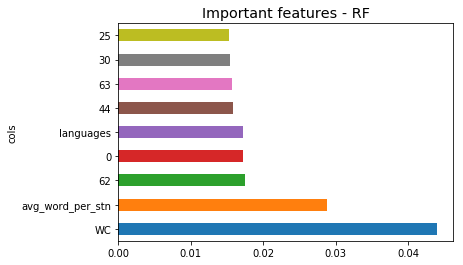

In [242]:
feat_df = pd.DataFrame({'cols':x_train.columns, 'imp':rf.feature_importances_})
feat_df.sort_values(by='imp',ascending=False, inplace=True)
feat_df[feat_df.imp>0.015].plot('cols','imp', 'barh', legend=False)
plt.title('Important features - RF', fontsize = 'x-large')
plt.show()

In [192]:
confusion_matrix(y_test, y_pred_rf)

array([[  1,  96],
       [  1, 352]])

In [193]:
accuracy_score(y_test, y_pred_rf)

0.7844444444444445

### 4.1.2 LR

In [196]:
lg = LogisticRegression(random_state=10)

lg.fit(x_train, y_train)
y_pred_lg = lg.predict(x_test)
y_pred_proba_lg = lg.predict_proba(x_test)

In [197]:
confusion_matrix(y_test, y_pred_lg)

array([[  5,  92],
       [ 15, 338]])

In [198]:
accuracy_score(y_test, y_pred_lg)

0.76222222222222225

### 4.1.3 SVC

In [201]:
clf = SVC()
clf.fit(x_train, y_train)

y_pred_sv = clf.predict(x_test)

In [203]:
confusion_matrix(y_test, y_pred_sv)

array([[  0,  97],
       [  0, 353]])

In [204]:
accuracy_score(y_test, y_pred_sv)

0.7844444444444445

## 4.2 Without stop words 

In [23]:
X_no, y_no = count_words_df_no.drop(['transcript','norm_persuasive','new_num','new_transcript','new_transcript_no'],axis=1),\
        [1 if a > 3.5 else 0 for a in count_words_df.new_num]
    
x_train1, x_test1, y_train1, y_test1 = train_test_split(X_no, y_no, test_size=.2,random_state=10)

### 4.2.1 RF

In [24]:
rf = RandomForestClassifier(n_estimators=100, random_state=10)
rf.fit(x_train1, y_train1)
y_pred_rf = rf.predict(x_test1)
y_pred_proba_rf = rf.predict_proba(x_test1)

In [25]:
confusion_matrix(y_test, y_pred_rf)

array([[  0,  97],
       [  1, 352]])

In [26]:
accuracy_score(y_test, y_pred_rf)

0.78222222222222226

### 4.2.2 LR

In [27]:
lg = LogisticRegression(random_state=10)

lg.fit(x_train, y_train)
y_pred_lg = lg.predict(x_test)
y_pred_proba_lg = lg.predict_proba(x_test)

confusion_matrix(y_test, y_pred_lg)

array([[  5,  92],
       [ 15, 338]])

In [28]:
accuracy_score(y_test, y_pred_lg)

0.76222222222222225

### 4.2.3 SVC

In [29]:
clf = SVC()
clf.fit(x_train, y_train)

y_pred_sv = clf.predict(x_test)

confusion_matrix(y_test, y_pred_sv)

array([[  0,  97],
       [  0, 353]])

In [30]:
accuracy_score(y_test, y_pred_sv)

0.7844444444444445

### 4.3.1 Imbalanced label - Under-sampling

In [31]:
rus = RandomUnderSampler(ratio=.3, random_state=42)
x_res, y_res = rus.fit_sample(x_train, y_train)

/Users/shen/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [33]:
# rf
rf = RandomForestClassifier(n_estimators=100, random_state=10)
rf.fit(x_res, y_res)
y_pred_rf = rf.predict(x_test)
y_pred_proba_rf = rf.predict_proba(x_test)
confusion_matrix(y_test, y_pred_rf)

array([[  2,  95],
       [  3, 350]])

In [34]:
accuracy_score(y_test, y_pred_rf)

0.78222222222222226

In [42]:
#lg
lg.fit(x_res, y_res)
y_pred_lg = lg.predict(x_test)
y_pred_proba_lg = lg.predict_proba(x_test)

confusion_matrix(y_test, y_pred_lg)

array([[  8,  89],
       [ 12, 341]])

In [43]:
accuracy_score(y_test, y_pred_lg)

0.77555555555555555

In [45]:
# svc
clf.fit(x_res, y_res)
y_pred_sv = clf.predict(x_test)

In [46]:
confusion_matrix(y_test, y_pred_sv)

array([[  0,  97],
       [  0, 353]])

In [47]:
accuracy_score(y_test, y_pred_sv)

0.7844444444444445

### 4.3.2 Imbalanced label - Over-sampling

In [48]:
ros = RandomOverSampler(ratio=.7, random_state=40)

x_res, y_res = ros.fit_sample(x_train, y_train)

# rf
rf = RandomForestClassifier(n_estimators=100, random_state=10)
rf.fit(x_res, y_res)
y_pred_rf = rf.predict(x_test)
y_pred_proba_rf = rf.predict_proba(x_test)
confusion_matrix(y_test, y_pred_rf)

/Users/shen/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[  1,  96],
       [  4, 349]])

In [49]:
accuracy_score(y_test, y_pred_rf)

0.77777777777777779

In [50]:
# lr
lg.fit(x_res, y_res)
y_pred_lg = lg.predict(x_test)
y_pred_proba_lg = lg.predict_proba(x_test)

In [51]:
confusion_matrix(y_test, y_pred_lg)

array([[ 37,  60],
       [ 82, 271]])

In [52]:
accuracy_score(y_test, y_pred_lg)

0.68444444444444441

In [53]:
# svc
clf.fit(x_res, y_res)
y_pred_lg = clf.predict(x_test)

In [54]:
confusion_matrix(y_test, y_pred_lg)

array([[  1,  96],
       [  6, 347]])

In [55]:
accuracy_score(y_test, y_pred_lg)

0.77333333333333332

# 5. Persuasive Features Visualization

In [57]:
inv_map = {}
for k, v in word_category_dict.items():
    inv_map[v] = inv_map.get(v, [])
    inv_map[v].append(k)

In [89]:
count_words_df[0].describe()

count    2249.000000
mean        1.293014
std         1.197328
min         0.000000
25%         0.530598
50%         0.937175
75%         1.629802
max        10.702499
Name: 0, dtype: float64

In [97]:
count_words_df[count_words_df[0]>5]['transcript']

33      I'll just take you to Bangladesh for a minute....
109     Thank you very much, Chris. Everybody who came...
131     I really am honored to be here, and as Chris s...
136     I am very, very happy to be amidst some of the...
152     You know, there's a small country nestled in t...
528     Thirteen trillion dollars in wealth has evapor...
538     A few years ago, my eyes were opened to the da...
621     So, basically we have public leaders, public o...
845     Well, this is about state budgets. This is pro...
979     I am a reformed marketer, and I now work in in...
1108    The recent debate over copyright laws like SOP...
1115    The recent debate over copyright laws like SOP...
1146    America's public energy conversation boils dow...
1243    In System D, this is a store, and what I mean ...
1273    Companies are losing control. What happens on ...
1318    In 2002, a group of treatment activists met to...
1345    This is about a hidden corner of the labor mar...
1356    "When 

In [104]:
words = str(count_words_df[count_words_df[0]>5]['transcript'][33])

In [74]:
from wordcloud import WordCloud, STOPWORDS

In [105]:
wordcloud = WordCloud(max_words=1000,width = 1000, height = 500).generate(words)

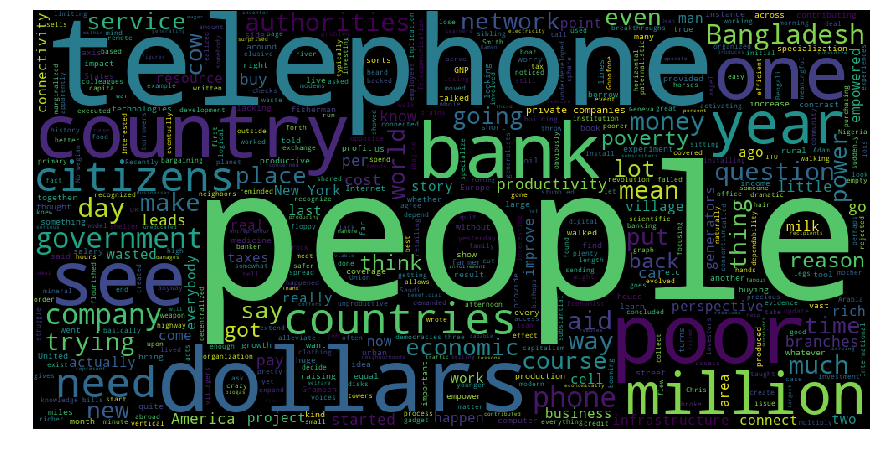

In [106]:
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()